In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from numpy.random import Generator, PCG64

In [2]:
#WARNING!!!!!!!!!!!!!!: PLEASE IF YOU WANT TO RECOMPILE ALL OF THIS REMEMBER IT WILL NEED A LOT OF TIME

# Parameters links

In this last part of the tutoring, I would like to talk about an interesting topic which is the parameter links. This topic can be divided in two macro aspects:

- The parameters's "weights" on the equations
- The links between the parameters

Talking about the first one, when we are working with a complex model there are usually a lot of parameters to consider. To perform an analysis of the entire parameter space as done before is impossible and also the qualitative analysis can be quite a mess. The equations (we will see it below) are usually not easily writable in a single clean form but we have to use "converters". In this chaos, if we are able to eliminate some parameters by our analysis could be very helpful. We will try to see if there are some way to understand which parameters can be fixed during our analysis. About this I will not talk about in this section because it will be a very long topic which require some qualitative analysis coadjuvate by some simulations.

The second points also regards the number of the parameters. In fact, sometimes, we have that our system do not depend directly on the absolut value of a parameter but to the ratio or a relationship with another parameter. This fact can give us the opportunity to reduce the total number of parameters in our system and doing so we can reduce the number of computation or considerations needed to study the behaviour of the system. I would like to talk about this.

## Premises

Finding the links between the parameters should be ideally done using qualitative analysis however, especially in very complex systems, it's almost impossible to do so (differential equations with 30+ terms). On the other hand, using for this little explanation a such complex system will require a lot of time also to explain merely the equations and the relationships between the variables. For this reason we will cheat a bit considering our well-known **harvest process** where we know that there is a relation ship between $k/a_0$. 

## Step 1

So considering the harvest process, we have the following equation that describe our system:

$$
\frac{dx}{dt}=a_0(x(1-x))-kx-s(x(1-x))\xi(t)
$$

and let's imagine we are not able to do any kind of qualitative analysis. We want to try if there are some links between.

To hold our scenario in the easiest situation,let's cheat again another bit and let's fix, at least at first, s=0.0001 that will simulate the situation with almost no $s$. We know in fact that for growing $s$ the attractor point moves and we want to keep $s$ fixed in first instance. 

Now we can imagine that if there are some kind of relationship between $a_0$ and $k$ (e.g. $k^2/a_0=cost.$) we will have that some distributions for different combinations should coincide with a small error in comparison with the others. Obviously this is not an absolut method and the choice for the distance and other aspects can influence a lot our results but we can be improved initializing all the time the method using the same seeds for all the levels of RNG. For this small experiment we will simply look to the results using a lot of simulations but keeping our seed random.

Before starting, we will need this time a new distance because the Kullback-Leiber request of having $Q>0$ is too tight when we confront two binning distributions. For this notebook I will use the **total variation distance** in its equivalence with the $L^1$ norm

$$
\delta(P,Q)=\frac{1}{2}\sum_{k=1}^n |P(x_k)-Q(x_k)|
$$

This has no problems with 0 values.

In [3]:
def total_var_dist(P:np.array,Q:np.array,h:float)->float:
    '''
    This function will compute the total variation distance 
    using the equivalence with the L^1 norm.
    '''

    if(len(P)!=len(Q)):
        raise RuntimeError("The length of the arrays of the two distributions must be the same")

    dist=0.0
    
    for i in range(len(P)):
        dist += np.abs(P[i]-Q[i])

    return dist/2
    

## Step 2

Now we can sample $a_0$ and $k$. We have not a precise idea where we want to look more than $a_0,k>0$ so let's take the domain $[0.001,1.0]$ for both of them. We start from this value because for lower have almost no sense and we have also impose non 0 condition for $a_0$ and $k$ also in the problem. We will only sample 9 points each to make it easier as possible (it's important because we will need to compute the cross distance between all the computations).

In [4]:
N= 9

a_grid = np.linspace(0.001,1.0,N)
k_grid = np.linspace(0.001,1.0,N)

print(a_grid)
print(k_grid)

[0.001    0.125875 0.25075  0.375625 0.5005   0.625375 0.75025  0.875125
 1.      ]
[0.001    0.125875 0.25075  0.375625 0.5005   0.625375 0.75025  0.875125
 1.      ]


Let's now import the usual class

In [5]:
#THE CLASS

class Harvest(object):
    '''
    This function will simulate trajectories for an initialize
    perturbed logistic system
    '''
    def __init__(self,a0: float,k: float,s:float)->None:
        self.a0 = a0
        self.k = k
        self.s = s

        if(a0<=0 or k<=0 or s<=0):
            raise RuntimeError("One of the given parameter is 0 or negative")
        
        return

    def __checkInputs(self,x0: float,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        if x0<0:
            raise RuntimeError("Initial population must be positive")

        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return

    def __RK4(self,t_n: float,y_n: float,h: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4 for the 
        deterministic part of the PLS
        '''
        self.__checkInputs(y_n,t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: self.a0*x*(1-x)-self.k*x
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory for the PLS.
        '''
        self.__checkInputs(x0,T,N)

        if T==0:
            return np.array([x0])

        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        rng = Generator(PCG64())

        for i in range(1,N+1):
            time[i] = i*h
            dx = self.__RK4(time[i-1],traj[i-1],h) 
            dx += self.s*traj[i-1]*(1.0-traj[i-1])*rng.normal()*np.sqrt(h) 
            traj[i] = traj[i-1] + dx
            if traj[i]<0: traj[i]=0.0

        return traj,time

Now for each combination of parameters we want to compute the distribution and then save them in vector.

In [18]:
#PRODUCTION CODE

omega = [0,1] 
Nbins = 250 
Nsim = 1000
m = (omega[1]-omega[0])/Nbins

#Create the matrix to save all the distributions
distributions = np.zeros((N,N,Nbins),dtype=float)

for k in range(len(a_grid)):
    for j in range(len(k_grid)):
        #SAME OLD THINGS
        system = Harvest(a_grid[k],k_grid[j],0.0001) #We only change here to pass the parameters values!
        
        rng_0 = Generator(PCG64())
        
        bins = np.zeros(Nbins,dtype=float)
        
        for _ in range(Nsim):
            ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
            for i in range(Nbins):
                if ptraj[-1] < (m*(i+1)+omega[0]):
                    bins[i] += 1.0
                    break

        t_bins = bins/(Nsim*m)

        distributions[k,j,:]=t_bins #And here we save the values into the array

## Step 3

Now we can compute all the cross distances and now we can see why we have keep the value of $N$ quite low. Also being the distance symmetric we can simply compute half of the matrix and also the diagonal is trivially null.

In [19]:
import math 
#I import math to use the floor function!

In [20]:
#Prepare the names for the axis' ticks
sets_names = []

for i in range(N):
    for j in range(N):
        sets_names.append(str(i)+"-"+str(j))

In [21]:
#Compute the matrix of the cross distances
dist = np.zeros((N**2,N**2),dtype=float)

for i in range(N**2):
    for j in range(N**2):
        if(j>=i+1):
            dist[i,j]=total_var_dist(distributions[math.floor(i/N),i%N,:],distributions[math.floor(j/N),j%N,:],m)

C:\Users\loren\AppData\Local\Temp\ipykernel_13560\4153022345.py:27: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(np.arange(N**2),np.arange(N**2),np.log(dist),cmap="plasma")


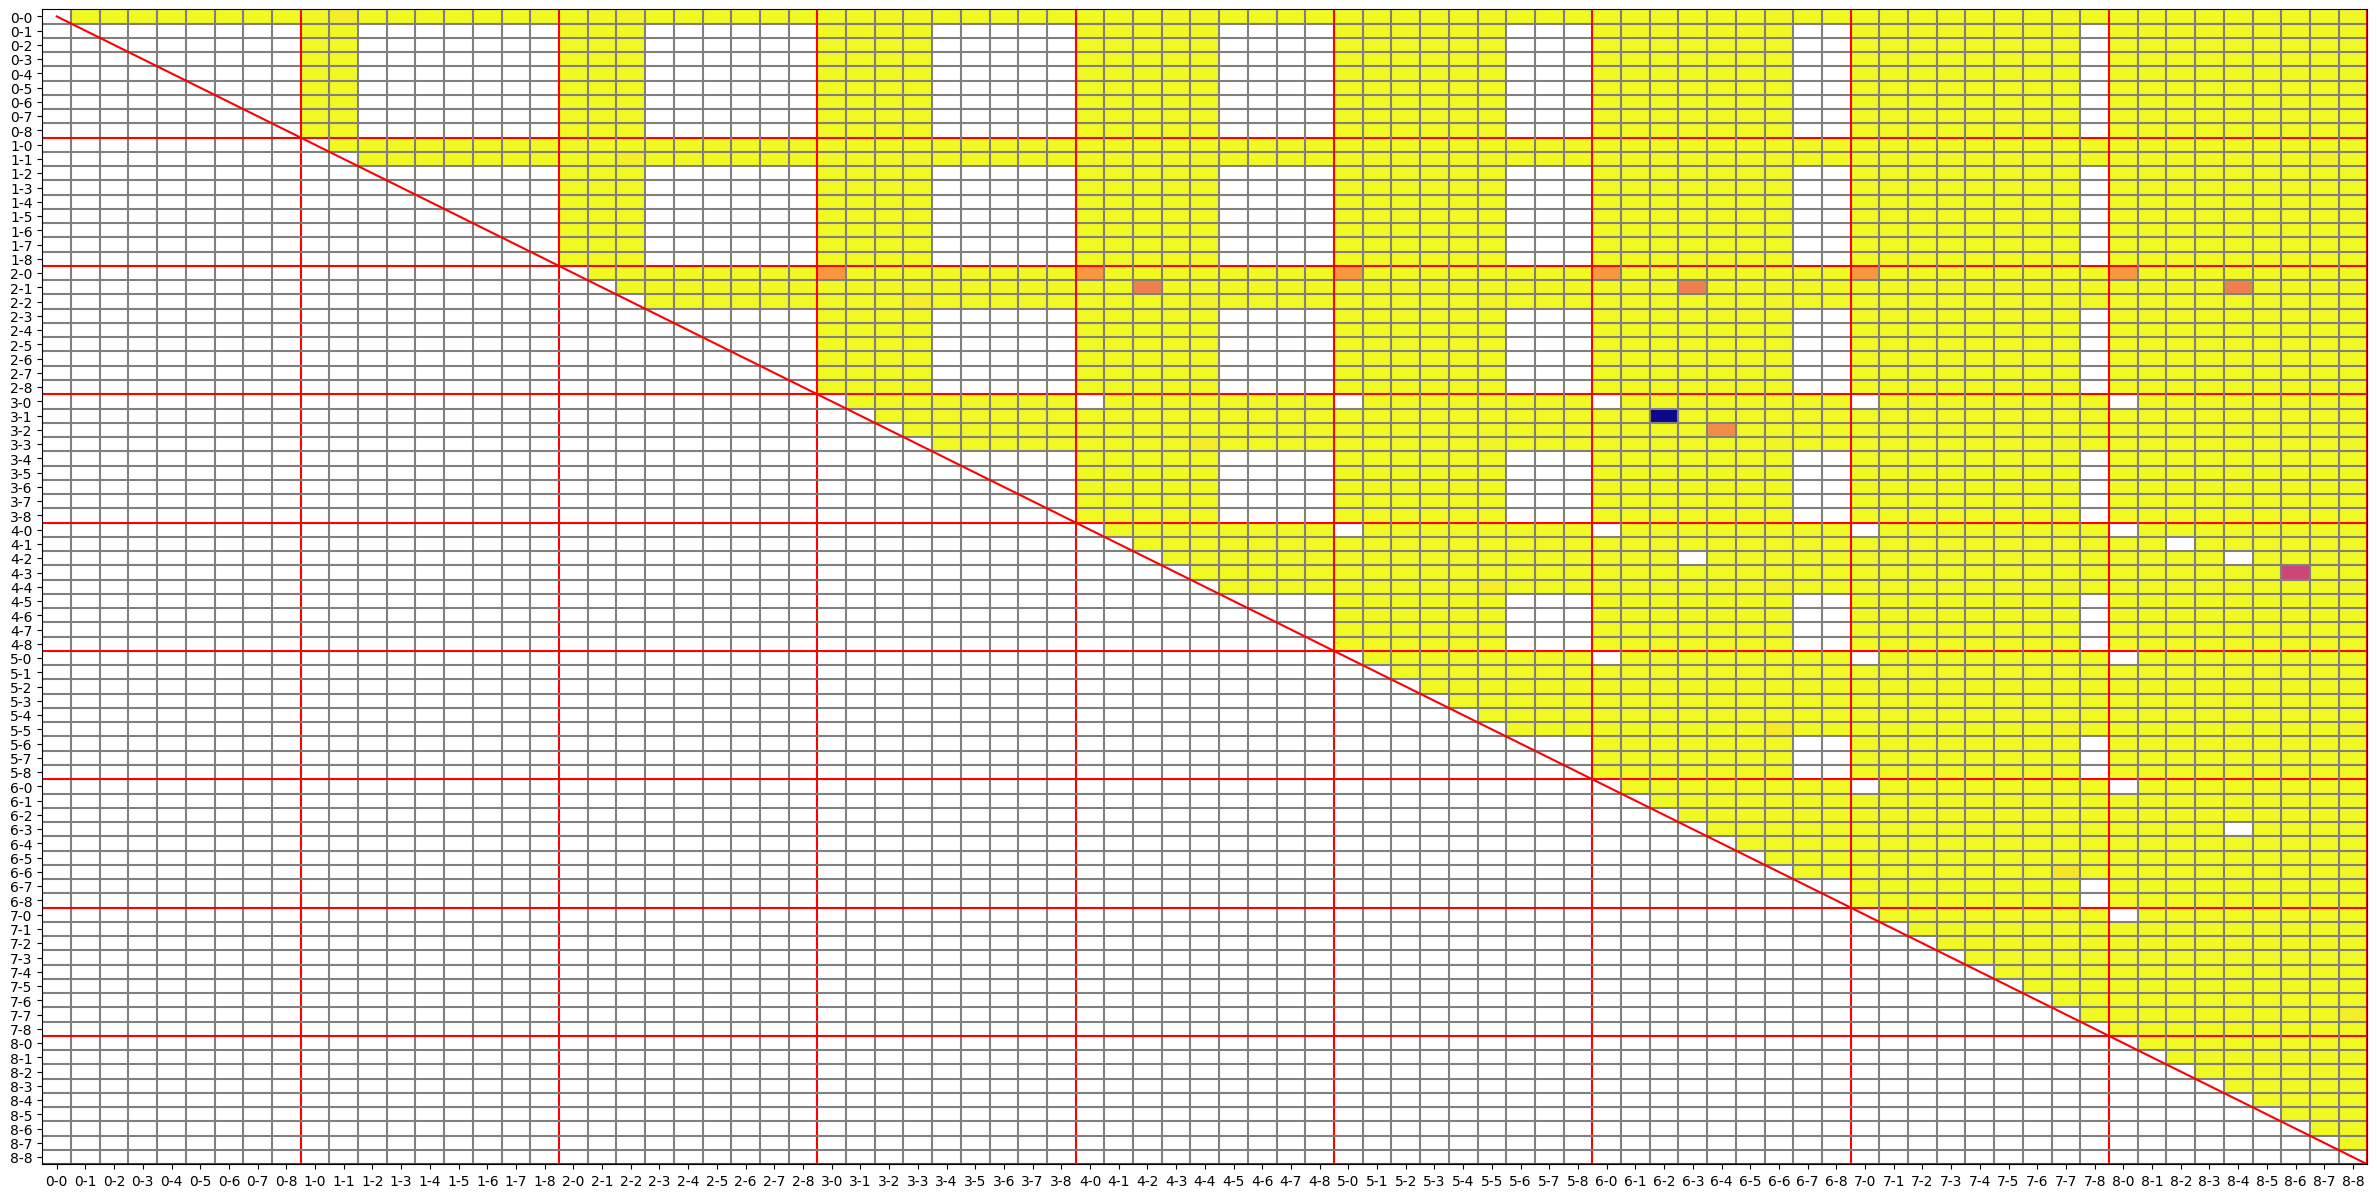

In [22]:
#YAH! IT'S PLOTTING TIME!


fig = plt.figure(figsize=(30, 15)) #Bigger figure
plt.gca().invert_yaxis() #Invert y axis to have the same form of the dist vector
plt.xticks(np.arange(N**2),sets_names) #Ticks label on x
plt.yticks(np.arange(N**2),sets_names) #Ticks label on y

#Horizontal and vertical grid
for i in range(N**2):
    if(i%N!=N-1):
        plt.axhline(y=i+0.5, color='grey', linestyle='-')
        plt.axvline(x=i+0.5, color='grey', linestyle='-')
    else:
        plt.axhline(y=i+0.5, color='r', linestyle='-')
        plt.axvline(x=i+0.5, color='r', linestyle='-')
        

#Diagonal line
x = np.linspace(0,N**2,100)
plt.plot(x,x,color='r')

plt.xlim(-0.5,N**2-0.5)
plt.ylim(N**2-0.5,-0.5)

#The actual colormesh plot
plt.pcolormesh(np.arange(N**2),np.arange(N**2),np.log(dist),cmap="plasma")

WOW! There are a lot of things here. Let's try to analyze a bit what this colormesh is telling us:

- Firstly all the yellow cells have an enormous error so probably there are no links.
- Talking about the line of colored cells in 2-0: if we take a look to the junctions we can observe that all the couple are made with another *-0 distribution. So if $k=0$ we obtain the same plot. This is also visible for 3-0, 4-0, ... but this time the error is perfectly 0. For 1-0 there is no strong correlation so a further analysis is required. In this situation we have that $a_0=0.1258...$ so it's quite small. A possible problem could be the length of the simulations.
- Talking about the line of colored cells in 2-1: here if we look at junctions we can observe that 4-2, 6-3 and 8-4 have the same ratio which is 1/2. For the other two colored point below the same observation can be made.
- Talking about the orangish diagonal cells (sometimes is more visible than other): They are all for $k=a_0$ so again we have a same ratio convergence however for this $k/a_0$ the simulation is probably a bit cranky, as seen before, so the error is still higher.
- **NEWS**: we have white points. As you can observe there a lot of white points in our colormesh so it could be interesting to analyze why it happens: it's truly a link or there are some problems with the simulation/computation of the distances? To integrate this colormesh one could start to check the combinations simply plotting it to understand the problem and then looking to the other white cells trying to find some links. There is obviously something recurrent because we have a geometric scheme for this combinations. I leave it to you!

Obviously part of this analysis can be automatized using some methods to extract the lowest values etc... without losing an eye on this dazzeling but useful image

## Step 4

We can try now a little bit redoing all of this computation but with $s=0.25$ which is a bigger but not an huge value.

In [11]:
#PRODUCTION CODE

omega = [0,1] 
Nbins = 250 
Nsim = 1000
m = (omega[1]-omega[0])/Nbins

#Create the matrix to save all the distributions
distributions = np.zeros((N,N,Nbins),dtype=float)

for k in range(len(a_grid)):
    for j in range(len(k_grid)):
        #SAME OLD THINGS
        system = Harvest(a_grid[k],k_grid[j],0.25) #We only change here to pass the parameters values!
        
        rng_0 = Generator(PCG64())
        
        bins = np.zeros(Nbins,dtype=float)
        
        for _ in range(Nsim):
            ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
            for i in range(Nbins):
                if ptraj[-1] < (m*(i+1)+omega[0]):
                    bins[i] += 1.0
                    break

        t_bins = bins/(Nsim*m)

        distributions[k,j,:]=t_bins #And here we save the values into the array

In [12]:
#Prepare the names for the axis' ticks
sets_names = []

for i in range(N):
    for j in range(N):
        sets_names.append(str(i)+"-"+str(j))

In [13]:
#Compute the matrix of the cross distances
dist = np.zeros((N**2,N**2),dtype=float)

for i in range(N**2):
    for j in range(N**2):
        if(j>=i+1):
            dist[i,j]=total_var_dist(distributions[math.floor(i/N),i%N,:],distributions[math.floor(j/N),j%N,:],m)

C:\Users\loren\AppData\Local\Temp\ipykernel_13560\4153022345.py:27: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(np.arange(N**2),np.arange(N**2),np.log(dist),cmap="plasma")


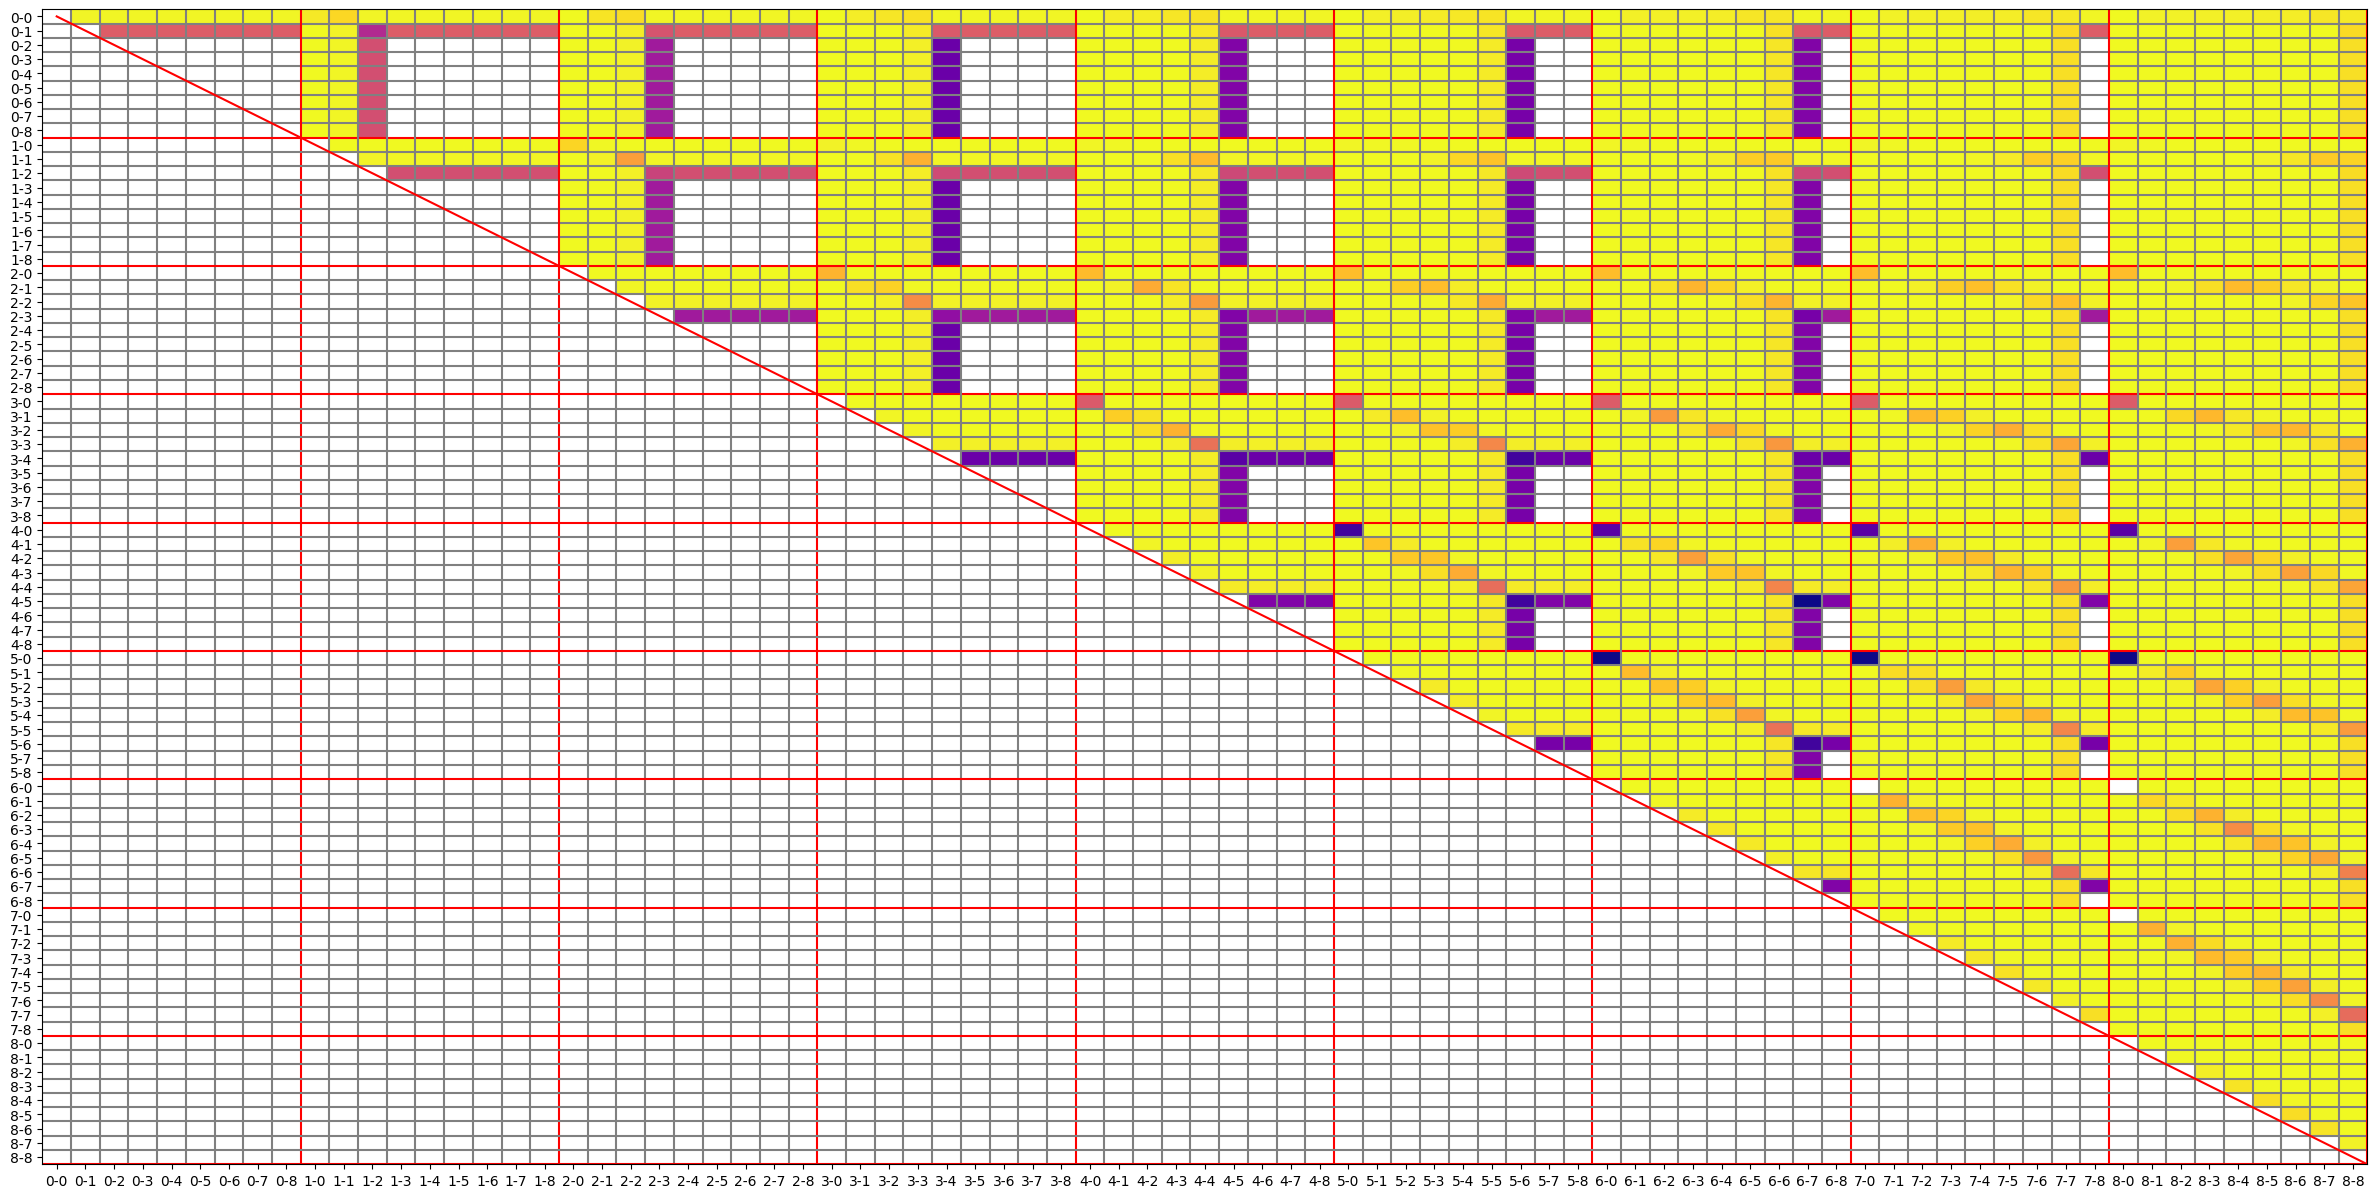

In [14]:
#YAH! IT'S PLOTTING TIME!


fig = plt.figure(figsize=(30, 15)) #Bigger figure
plt.gca().invert_yaxis() #Invert y axis to have the same form of the dist vector
plt.xticks(np.arange(N**2),sets_names) #Ticks label on x
plt.yticks(np.arange(N**2),sets_names) #Ticks label on y

#Horizontal and vertical grid
for i in range(N**2):
    if(i%N!=N-1):
        plt.axhline(y=i+0.5, color='grey', linestyle='-')
        plt.axvline(x=i+0.5, color='grey', linestyle='-')
    else:
        plt.axhline(y=i+0.5, color='r', linestyle='-')
        plt.axvline(x=i+0.5, color='r', linestyle='-')
        

#Diagonal line
x = np.linspace(0,N**2,100)
plt.plot(x,x,color='r')

plt.xlim(-0.5,N**2-0.5)
plt.ylim(N**2-0.5,-0.5)

#The actual colormesh plot
plt.pcolormesh(np.arange(N**2),np.arange(N**2),np.log(dist),cmap="plasma")

Well some of the previous behaviour are still present but we can see that the stochastic fluctuations depolarize some situations and transform some distributions making them similar!